In [51]:
def load(dataset = "training", path = "."):
    """
    Import either the training or testing MNIST data set.
    It returns a pair with the first element being the collection of
    images stacked in columns and the second element being a vector
    of corresponding labels from 0 to 9.

    Example:
        x, lbl = load(dataset = "training", path = "/datasets/MNIST")
    """
    import os
    import struct
    import numpy as np

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows * cols)

    img = np.moveaxis(img, 0, -1)

    return img, lbl

import os
import numpy as np
import matplotlib.pyplot as plt
data_used, label_used = load(dataset = 'training', path = 'MNIST')


In [66]:
def normalize_MNIST_images(x):
    x = np.array(x)
    val_max = np.max(x, axis = 0)
    val_min = np.min(x, axis = 0)
    
    x = 2 * (x - val_min) / (val_max - val_min) - 1
    return x.astype(np.float64)

def label2onehot(lbl):
    d = np.zeros((lbl.max() + 1, lbl.size))
    d[lbl, np.arange(0, lbl.size)] = 1
    return d

def onehot2label(d):
    lbl = d.argmax(axis = 0)
    return lbl

def activation_func(input_x, method = 'relu'):
    if method == 'relu':
        return np.multiply(input_x, input_x > 0) 

def activation_funcp(input_x, method = 'relu'):
    if method == 'relu':
        return input_x > 0



In [67]:

def build_net(net_paras):
    
    layer_num = len(net_paras)
    net_dict = dict()
    for i in range(1, layer_num):
        
        w_sigma = 1 / np.sqrt((net_paras[i-1]+1)/2)
        b_sigma = 1 / np.sqrt((net_paras[i-1]+1)/2)
                               
        net_dict['layer_wbaz' + str(i)] = [w_sigma * np.mat(np.random.randn(net_paras[i], net_paras[i-1])),
                                        b_sigma * np.mat(np.random.randn(net_paras[i], 1)),
                                        np.mat(np.zeros((net_paras[i],1))),
                                        np.mat(np.zeros((net_paras[i],1)))]
        
    return net_dict
    
    

In [68]:
def softmax(input_x):
    temp = np.exp(input_x - np.max( input_x, axis = 0))
    return temp / np.sum(temp,axis = 0)
    
def eval_loss(y,d):
    E = -(np.multiply(d,np.log(y)) + np.multiply((1-d),np.log(1-y))).mean()
    return E

In [69]:
def forward_prop(x, net):

    for i in range(1, len(net)+1):
        ai = net['layer_wbaz' + str(i)][0] * x + net['layer_wbaz' + str(i)][1]
        zi = activation_func(ai)
        net['layer_wbaz' + str(i)][2] = ai
        net['layer_wbaz' + str(i)][3] = zi
        x = zi
        #print('layer_wbaz' + str(i), net['layer_wbaz' + str(i)][0].shape)
        
    y = softmax(x)
    
    return y


In [70]:
def delta_softmax(y ,d):
    dE_dy = -(np.divide(d, y) + np.divide(1-d, 1-y))
    delta = np.multiply(y, dE_dy) - np.multiply(y, np.sum(np.multiply(y, dE_dy),axis = 0))

    return delta


In [71]:

def update_back_prop(x, d, net, gamma = 0.05):
    
    y = forward_prop(x, net)
    
    #print('update_len_net', len(net))
    
    delta_last = delta_softmax(y, d)
    delta_back = delta_last
    
    gamma = gamma / d.shape[1]
    
    for i in range(len(net) -1 , 0 , -1):
        delta_front = np.multiply( 
                        activation_funcp(net['layer_wbaz' + str(i)][2] ),
                        net['layer_wbaz' + str(i+1)][0].T * delta_back)
        
        # calculate delta of w and b
        delta_w_temp = np.dot(delta_back,
                             net['layer_wbaz' + str(i)][3].T)
        delta_b_temp = np.dot(delta_back,
                             np.ones((d.shape[1],1)))
        # update weight w and bias b
        
        net['layer_wbaz' + str(i+1)][0] -= gamma * delta_w_temp
        net['layer_wbaz' + str(i+1)][1] -= gamma * delta_b_temp
        
        delta_back = delta_front
        
    delta_w_temp = np.dot(delta_back, x.T)
    delta_b_temp = np.dot(delta_back, np.ones((x.shape[1],1)))
    '''
    print('delta_w_temp',delta_w_temp)
    print('delta_b_temp', delta_b_temp)
    '''
    net['layer_wbaz' + str(1)][0] -= gamma * delta_w_temp
    net['layer_wbaz' + str(1)][1] -= gamma * delta_b_temp
    
    return net
    

In [72]:
def back_prop( x, d, net, T, gamma = 0.05):
    from tqdm import tqdm_notebook as tqdm
    
    label = onehot2label(d)
    loss_train = []
    loss_test = []
    
    for t in tqdm(range(0,T)):
        
        net = update_back_prop(x, d, net, gamma = 0.05)
        y_temp_train = forward_prop(x, net)
        loss_train.append(eval_loss(y_temp_train, d))
        y_temp_test = forward_prop(x_test, net)
        loss_test.append(eval_loss(y_temp_test, d_test))
        
    plt.figure(1)
    plt.plot(loss_train)
    plt.plot(loss_test)
    plt.title('loss')
    plt.legend(['train loss','test loss'])
    plt.show()
    
    return net



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

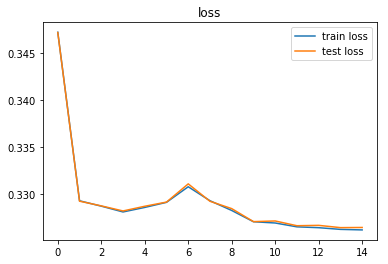

In [73]:
# input / hidden / output units
data_used = np.random.permutation(data_used.T).T

x_train = data_used[:,:50000]
y_train = label_used[:50000]

x_test = data_used[:,50000:]
y_test = label_used[50000:]

x_train = np.mat(normalize_MNIST_images(x_train))
x_test = np.mat(normalize_MNIST_images(x_test))
d_train = label2onehot(y_train)
d_test = label2onehot(y_test)

net_paras = [784, 64, 64, 10]
net_init = build_net(net_paras)
net = back_prop(x_train, d_train, net_init, 15, gamma = 0.03)
    